In [1]:
import os
import time 
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    
    if ret:  # Check if the frame was captured successfully
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("Failed to capture frame")
        
cap.release()
cv2.destroyAllWindows()

In [3]:
python opt_flow.py 0

SyntaxError: invalid syntax (452933108.py, line 1)

In [6]:
!labelme

2024-02-28 11:13:55,415 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Tejas\.labelmerc


In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [12]:
images.as_numpy_iterator().next()


b'data\\images\\faad7ae5-d5fb-11ee-9159-088fc30636c7.jpg'

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [14]:
images = images.map(load_image)

In [15]:
images.as_numpy_iterator().next()

array([[[175, 177, 176],
        [196, 198, 197],
        [219, 221, 220],
        ...,
        [190, 200, 199],
        [190, 200, 199],
        [189, 199, 198]],

       [[174, 176, 175],
        [201, 203, 202],
        [227, 229, 228],
        ...,
        [190, 200, 199],
        [190, 200, 199],
        [190, 200, 199]],

       [[176, 178, 177],
        [205, 207, 206],
        [234, 236, 235],
        ...,
        [191, 201, 200],
        [191, 201, 200],
        [191, 201, 200]],

       ...,

       [[114, 109, 105],
        [114, 109, 105],
        [114, 109, 103],
        ...,
        [118, 124, 120],
        [117, 123, 119],
        [119, 125, 121]],

       [[115, 110, 106],
        [115, 110, 106],
        [115, 110, 104],
        ...,
        [164, 170, 166],
        [165, 171, 167],
        [167, 173, 169]],

       [[116, 111, 107],
        [115, 110, 106],
        [115, 110, 104],
        ...,
        [152, 158, 154],
        [149, 155, 151],
        [144, 150, 146]]

In [16]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [17]:
image_generator = images.batch(4).as_numpy_iterator()

In [28]:
plot_images = image_generator.next()

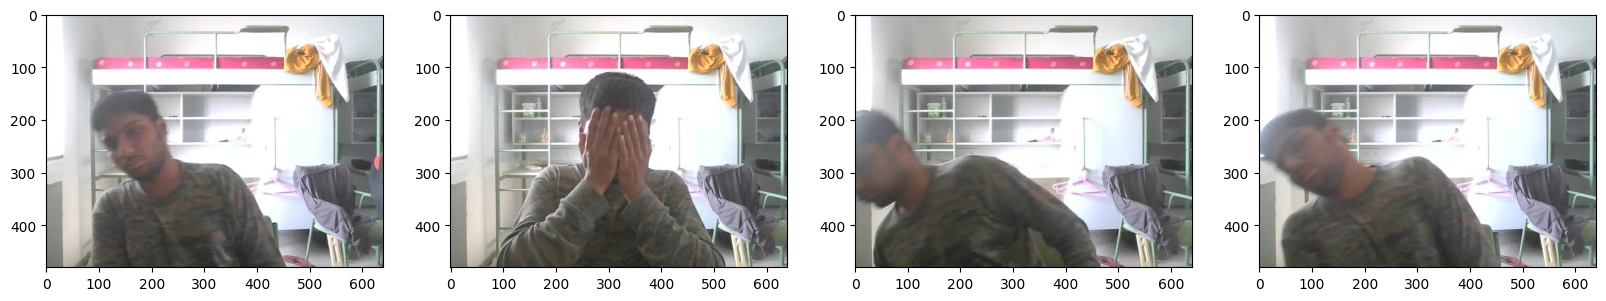

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [31]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

In [33]:
!labelme


2024-02-28 11:53:07,139 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Tejas\.labelmerc


In [34]:
import albumentations as alb

In [35]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [36]:
img = cv2.imread(os.path.join('data','train', 'images','a1d33405-d5fb-11ee-9049-088fc30636c7.jpg'))

In [38]:
img.shape

(480, 640, 3)

In [39]:
with open(os.path.join('data', 'train', 'labels', 'a1d33405-d5fb-11ee-9049-088fc30636c7.json'), 'r') as f:
    label = json.load(f)

In [41]:
label['shapes'][0]['points']

[[247.88461538461547, 93.84615384615381],
 [411.3461538461538, 320.76923076923083]]

In [42]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [43]:
coords

[247.88461538461547, 93.84615384615381, 411.3461538461538, 320.76923076923083]

In [44]:
coords = list(np.divide(coords, [640,480,640,480]))

In [45]:
coords

[0.3873197115384617,
 0.19551282051282043,
 0.6427283653846153,
 0.668269230769231]

In [46]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

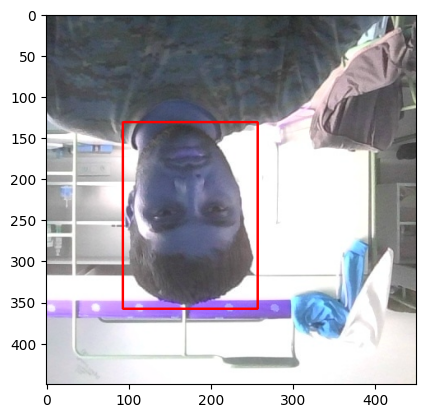

In [47]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [8]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'au

In [11]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [12]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [13]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [14]:
train_images.as_numpy_iterator().next()

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.87322307, 0.87322307, 0.87322307],
        [0.8815564 , 0.8815564 , 0.8815564 ],
        [0.8886642 , 0.8886642 , 0.8916054 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.87800246, 0.8701593 , 0.8740809 ],
        [0.8824142 , 0.889277  , 0.8858456 ],
        [0.8865809 , 0.88805145, 0.89528185]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.8779412 , 0.8779412 , 0.8779412 ],
        [0.8853554 , 0.8922181 , 0.8887868 ],
        [0.891973  , 0.8947304 , 0.8938113 ]],

       ...,

       [[0.42561275, 0.4177696 , 0.3707108 ],
        [0.43125   , 0.41409314, 0.37144607],
        [0.44276962, 0

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [16]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.22  , 0.1681, 0.5874, 0.6943], dtype=float16))

In [20]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4980, 4980, 780, 780, 900, 900)

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [70]:
train.as_numpy_iterator().next()

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2217, 0.3223, 0.644 , 0.89  ],
        [0.2654, 0.3757, 0.583 , 0.825 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5396, 0.332 , 0.93  , 0.8047],
        [0.2554, 0.4014, 0.562 , 0.814 ],
        [0.3035, 0.1792, 0.616 , 0.6104],
        [0.1587, 0.1497, 0.5273, 0.644 ],
        [0.4136, 0.3994, 0.7007, 0.7705]], dtype=float16))

In [24]:
data_samples = train.as_numpy_iterator()

In [25]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


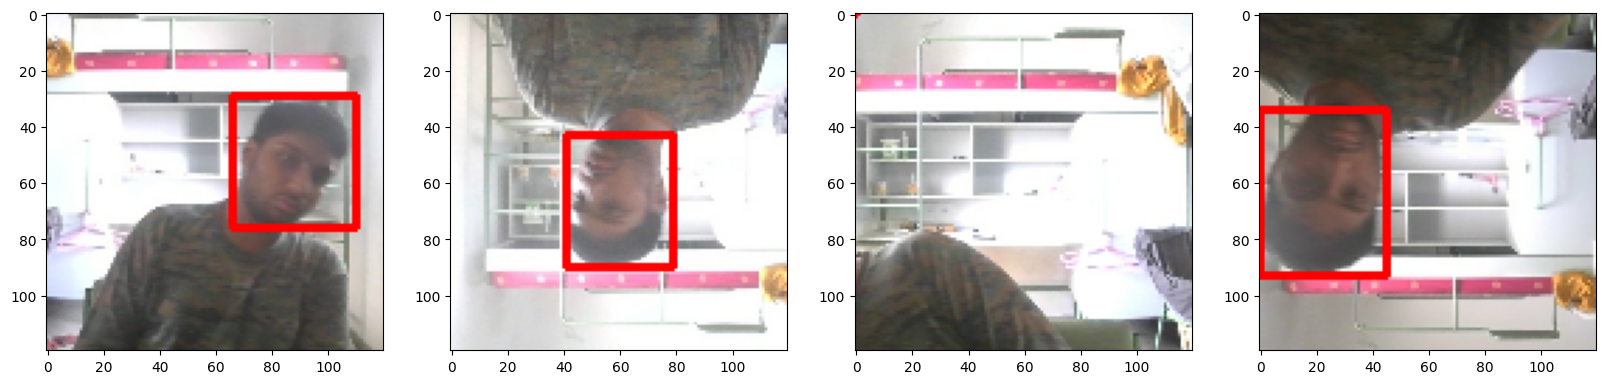

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Convert NumPy array to cv::Mat
    sample_image_cv = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)  # Convert to BGR format
    sample_image_cv = cv2.cvtColor(sample_image_cv, cv2.COLOR_BGR2RGB)  # Convert back to RGB for displaying
    
    # Draw rectangle
    cv2.rectangle(sample_image_cv, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 2)

    ax[idx].imshow(sample_image_cv)

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [32]:
vgg = VGG16(include_top=False)

In [33]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [34]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [35]:
facetracker = build_model()

In [98]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [36]:
X, y = train.as_numpy_iterator().next()

In [37]:
X.shape

(8, 120, 120, 3)

In [38]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [103]:
classes, coords

(array([[0.32512158],
        [0.2778985 ],
        [0.27929798],
        [0.31822413],
        [0.30220866],
        [0.3243266 ],
        [0.34816453],
        [0.27333978]], dtype=float32),
 array([[0.64484626, 0.6786792 , 0.31431174, 0.49226007],
        [0.5942784 , 0.6600104 , 0.36418173, 0.50488895],
        [0.55066556, 0.68885094, 0.3509886 , 0.5841011 ],
        [0.515984  , 0.7434285 , 0.37605783, 0.5513336 ],
        [0.5839688 , 0.6516279 , 0.35149404, 0.5814838 ],
        [0.602514  , 0.71365464, 0.4300101 , 0.6013965 ],
        [0.47520837, 0.70958024, 0.37616625, 0.5554043 ],
        [0.5301099 , 0.68431294, 0.38302293, 0.64145434]], dtype=float32))

In [39]:
len(train)

623

In [40]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [41]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [42]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [43]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [44]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.3646219>

In [45]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.41632006>

In [46]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.3646219>

In [47]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [48]:
model = FaceTracker(facetracker)

In [49]:
model.compile(opt, classloss, regressloss)

In [50]:
logdir='logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [52]:
hist = model.fit(train, epochs=12, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/12
623/623 [==============================] - 71s 97ms/step - total_loss: 0.3593 - class_loss: 0.1124 - regress_loss: 0.3031 - val_total_loss: 0.0129 - val_class_loss: 0.0037 - val_regress_loss: 0.0111
Epoch 2/12
623/623 [==============================] - 58s 85ms/step - total_loss: 0.0950 - class_loss: 0.0317 - regress_loss: 0.0791 - val_total_loss: 0.0344 - val_class_loss: 0.0011 - val_regress_loss: 0.0338
Epoch 3/12
623/623 [==============================] - 58s 85ms/step - total_loss: 0.0668 - class_loss: 0.0240 - regress_loss: 0.0548 - val_total_loss: 0.0110 - val_class_loss: 1.1785e-04 - val_regress_loss: 0.0110
Epoch 4/12
623/623 [==============================] - 58s 85ms/step - total_loss: 0.0386 - class_loss: 0.0140 - regress_loss: 0.0316 - val_total_loss: 0.0185 - val_class_loss: 2.9906e-04 - val_regress_loss: 0.0183
Epoch 5/12
623/623 [==============================] - 58s 85ms/step - total_loss: 0.0311 - class_loss: 0.0108 - regress_loss: 0.0257 - val_total_loss: 0

In [53]:
hist.history

{'total_loss': [0.017720574513077736,
  0.011775645427405834,
  0.01870090886950493,
  0.011065238155424595,
  0.0036429925821721554,
  0.003326691221445799,
  0.00274847075343132,
  0.002503711264580488,
  0.0009067371720448136,
  0.0014347205869853497,
  0.003466637572273612,
  0.001697656698524952],
 'class_loss': [0.008742161095142365,
  0.0029988421592861414,
  0.010541531257331371,
  0.00010701248538680375,
  0.00037013087421655655,
  0.001478818478062749,
  0.0001351223181700334,
  0.00015950080705806613,
  3.309688327135518e-05,
  3.3201180485775694e-05,
  5.662468083755812e-06,
  2.9564542273874395e-05],
 'regress_loss': [0.013349493965506554,
  0.010276224464178085,
  0.013430142775177956,
  0.011011731810867786,
  0.003457927145063877,
  0.0025872820988297462,
  0.002680909587070346,
  0.0024239609483629465,
  0.0008901887340471148,
  0.0014181199949234724,
  0.003463806351646781,
  0.0016828743973746896],
 'val_total_loss': [0.012922736816108227,
  0.03435847908258438,
  0.

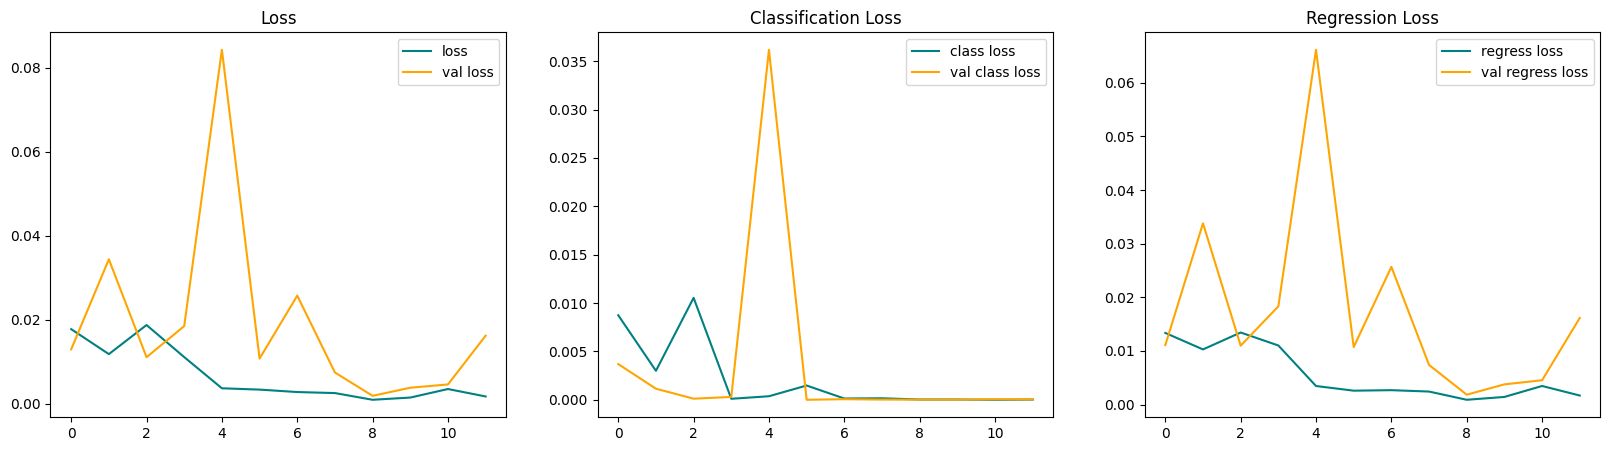

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [55]:
test_data = test.as_numpy_iterator()

In [76]:
test_sample = test_data.next()

In [77]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


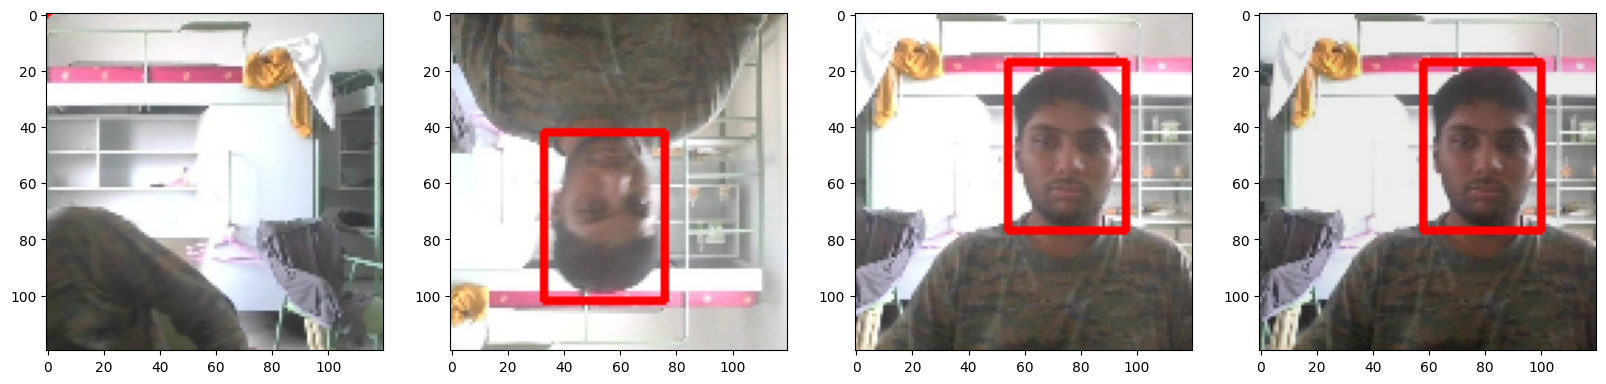

In [78]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    # Convert NumPy array to cv::Mat
    sample_image_cv = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)  # Convert to BGR format
    sample_image_cv = cv2.cvtColor(sample_image_cv, cv2.COLOR_BGR2RGB)  # Convert back to RGB for displaying
    
    # Draw rectangle
    cv2.rectangle(sample_image_cv, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 2)

    ax[idx].imshow(sample_image_cv)

In [3]:
from tensorflow.keras.models import load_model

In [80]:
facetracker.save('facetracker.h5')

In [4]:
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
